# Explorative Datenanalyse: Mental Health in Tech 2016

In [2]:
import pandas as pd

# Daten laden
df = pd.read_csv('data/mental-heath-in-tech-2016_20161114.csv')

# Grundlegende Informationen
print(f"Teilnehmer (Zeilen): {df.shape[0]}")
print(f"Variablen (Spalten): {df.shape[1]}")

Teilnehmer (Zeilen): 1433
Variablen (Spalten): 63


In [3]:
# Datentypen aller Spalten
print("Datentypen der 63 Variablen:\n")
for i, (col, dtype) in enumerate(df.dtypes.items(), 1):
    print(f"{i:2}. [{dtype}] {col[:70]}")

Datentypen der 63 Variablen:

 1. [int64] Are you self-employed?
 2. [object] How many employees does your company or organization have?
 3. [float64] Is your employer primarily a tech company/organization?
 4. [float64] Is your primary role within your company related to tech/IT?
 5. [object] Does your employer provide mental health benefits as part of healthcar
 6. [object] Do you know the options for mental health care available under your em
 7. [object] Has your employer ever formally discussed mental health (for example, 
 8. [object] Does your employer offer resources to learn more about mental health c
 9. [object] Is your anonymity protected if you choose to take advantage of mental 
10. [object] If a mental health issue prompted you to request a medical leave from 
11. [object] Do you think that discussing a mental health disorder with your employ
12. [object] Do you think that discussing a physical health issue with your employe
13. [object] Would you feel comfortable discus

In [ ]:
# =============================================================================
# FEATURE-TYPEN KLASSIFIZIERUNG
# =============================================================================
# Robuste Version: Verwendet Spalten-Indizes statt Namen (wegen Encoding-Problemen)

cols = df.columns.tolist()

FEATURE_TYPES = {
    'kategorisch_binaer': [
        cols[0],
        cols[2],
        cols[3],
        cols[16],
        cols[24],
        cols[50],
        cols[52],
    ],
    
    'kategorisch_ordinal': [
        cols[1],
        cols[9],
        cols[23],
        cols[42],
        cols[53],
        cols[54],
        cols[62],
    ],
    
    'kategorisch_nominal': [
        cols[4], cols[5], cols[6], cols[7], cols[8],
        cols[10], cols[11], cols[12], cols[13], cols[14],
        cols[15], cols[17], cols[18], cols[19], cols[20],
        cols[21], cols[22],
        cols[25], cols[26], cols[27], cols[28], cols[29],
        cols[30], cols[31], cols[32], cols[33], cols[34],
        cols[35], cols[36], cols[38],
        cols[40], cols[41], cols[43], cols[44],
        cols[45], cols[46], cols[47],
        cols[56], cols[57], cols[58], cols[59], cols[60],
    ],
    
    'kategorisch_multival': [
        cols[48],
        cols[49],
        cols[51],
        cols[61],
    ],
    
    'text_freitext': [
        cols[37],
        cols[39],
    ],
    
    'numerisch_verhaeltnis': [
        cols[55],
    ],
}

# Validierung
print("Feature-Typen Validierung:")
total = 0
for typ, spalten in FEATURE_TYPES.items():
    print(f"  {typ}: {len(spalten)} Spalten")
    total += len(spalten)
print(f"\nGesamt: {total} von {len(cols)} Spalten klassifiziert")

Feature-Typen Validierung:
  kategorisch_binaer: 7 Spalten
  kategorisch_ordinal: 7 Spalten
  kategorisch_nominal: 42 Spalten
  kategorisch_multival: 4 Spalten
  text_freitext: 2 Spalten
  numerisch_verhaeltnis: 1 Spalten

Gesamt: 63 von 63 Spalten klassifiziert


In [13]:
import missingno as msno
import matplotlib.pyplot as plt

# Übersicht: Fehlende Werte pro Spalte
missing_stats = pd.DataFrame({
    'Spalte': df.columns,
    'Missing': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df) * 100).round(1),
    'Vorhanden': df.notnull().sum(),
    'Dtype': df.dtypes.values
}).sort_values('Missing %', ascending=False)

print(f"Gesamt: {df.isnull().sum().sum()} fehlende Werte")
print(f"Spalten mit Missing Values: {(missing_stats['Missing'] > 0).sum()} von {len(df.columns)}")
print(f"\nTop 15 Spalten nach Missing-Rate:\n")
print(missing_stats.head(15).to_string(index=False))

Gesamt: 21960 fehlende Werte
Spalten mit Missing Values: 44 von 63

Top 15 Spalten nach Missing-Rate:

                                                                                                                                                                          Spalte  Missing  Missing %  Vorhanden   Dtype
                                                    If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?     1289       90.0        144  object
                                            If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?     1229       85.8        204  object
                                                                                                                    Is your primary role within your company related to tech/IT?     1170       81.6        263 float64
                                 

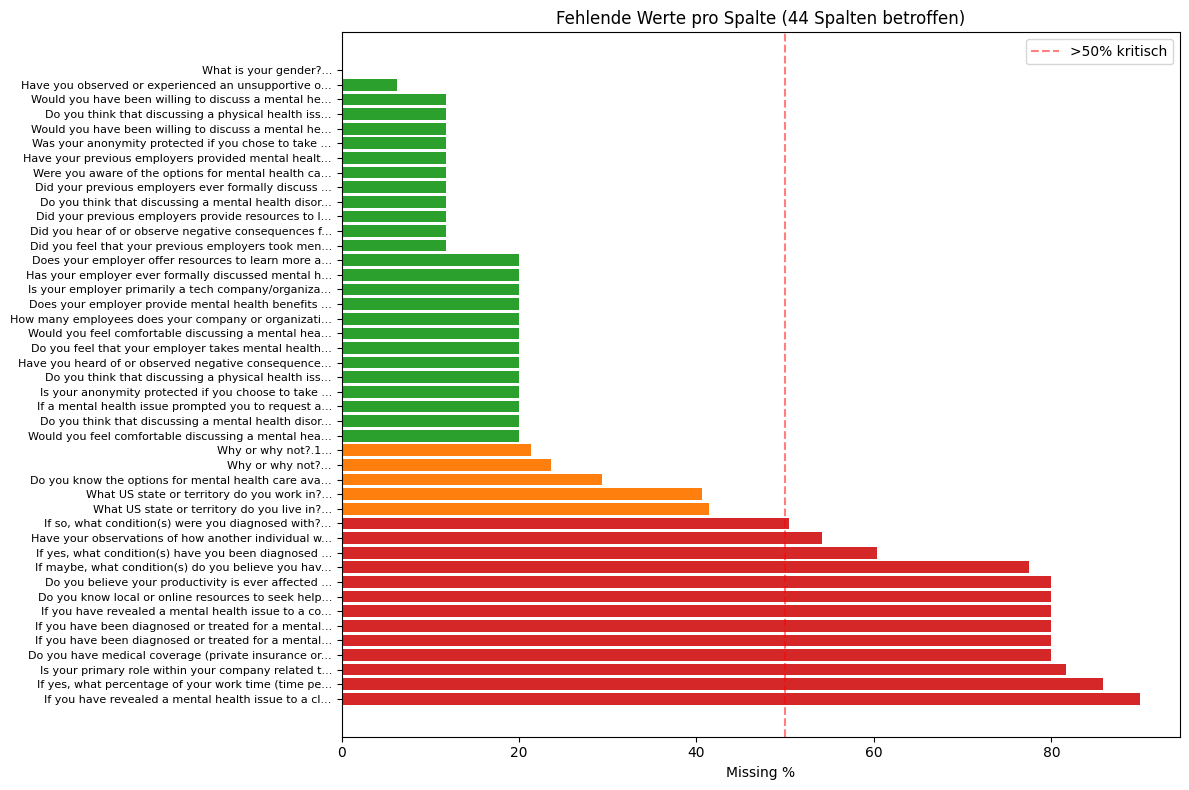

In [14]:
# Balkendiagramm: Nur Spalten mit fehlenden Werten
missing_only = missing_stats[missing_stats['Missing'] > 0].copy()

if len(missing_only) > 0:
    plt.figure(figsize=(12, 8))
    
    # Kurze Spaltennamen für Lesbarkeit
    missing_only['Kurz'] = missing_only['Spalte'].str[:50] + '...'
    
    colors = ['#d62728' if x > 50 else '#ff7f0e' if x > 20 else '#2ca02c' 
              for x in missing_only['Missing %']]
    
    plt.barh(range(len(missing_only)), missing_only['Missing %'], color=colors)
    plt.yticks(range(len(missing_only)), missing_only['Kurz'], fontsize=8)
    plt.xlabel('Missing %')
    plt.title(f'Fehlende Werte pro Spalte ({len(missing_only)} Spalten betroffen)')
    plt.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='>50% kritisch')
    plt.legend()
    plt.tight_layout()
    plt.savefig('plots/missing_bars.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Keine fehlenden Werte vorhanden!")

In [23]:
# =============================================================================
# NUMERISCH VERHÄLTNIS: Statistiken (Alter)
# =============================================================================

age_col = FEATURE_TYPES['numerisch_verhaeltnis'][0]
age_data = df[age_col].dropna()

print(f"NUMERISCHE VARIABLE: {age_col}\n")
print("="*50)
print(f"  n (gültig):      {age_data.count()}")
print(f"  n (fehlend):     {df[age_col].isna().sum()}")
print()
print(f"  Minimum:         {age_data.min()}")
print(f"  Maximum:         {age_data.max()}")
print(f"  Spannweite:      {age_data.max() - age_data.min()}")
print()
print(f"  Mittelwert:      {age_data.mean():.2f}")
print(f"  Median:          {age_data.median():.1f}")
print(f"  Modus:           {age_data.mode().iloc[0]}")
print()
print(f"  Standardabw.:    {age_data.std():.2f}")
print(f"  Varianz:         {age_data.var():.2f}")
print()
print(f"  25% Quartil:     {age_data.quantile(0.25):.1f}")
print(f"  50% Quartil:     {age_data.quantile(0.50):.1f}")
print(f"  75% Quartil:     {age_data.quantile(0.75):.1f}")
print(f"  IQR:             {age_data.quantile(0.75) - age_data.quantile(0.25):.1f}")

NUMERISCHE VARIABLE: What is your age?

  n (gültig):      1433
  n (fehlend):     0

  Minimum:         3
  Maximum:         323
  Spannweite:      320

  Mittelwert:      34.29
  Median:          33.0
  Modus:           30

  Standardabw.:    11.29
  Varianz:         127.49

  25% Quartil:     28.0
  50% Quartil:     33.0
  75% Quartil:     39.0
  IQR:             11.0


In [25]:
# Spalten mit vielen einzigartigen Werten (potentiell Freitext/inkonsistent)
print("Spalten mit >10 einzigartigen Werten:\n")

for col in df.columns:
    n_unique = df[col].nunique()
    if n_unique > 5 and df[col].dtype == 'object':
        print(f"{n_unique:>4} Werte | {col[:65]}")

Spalten mit >10 einzigartigen Werten:

   6 Werte | How many employees does your company or organization have?
   6 Werte | If a mental health issue prompted you to request a medical leave 
1085 Werte | Why or why not?
1080 Werte | Why or why not?.1
   6 Werte | How willing would you be to share with friends and family that yo
 128 Werte | If yes, what condition(s) have you been diagnosed with?
  99 Werte | If maybe, what condition(s) do you believe you have?
 116 Werte | If so, what condition(s) were you diagnosed with?
  70 Werte | What is your gender?
  53 Werte | What country do you live in?
  47 Werte | What US state or territory do you live in?
  53 Werte | What country do you work in?
  48 Werte | What US state or territory do you work in?
 264 Werte | Which of the following best describes your work position?


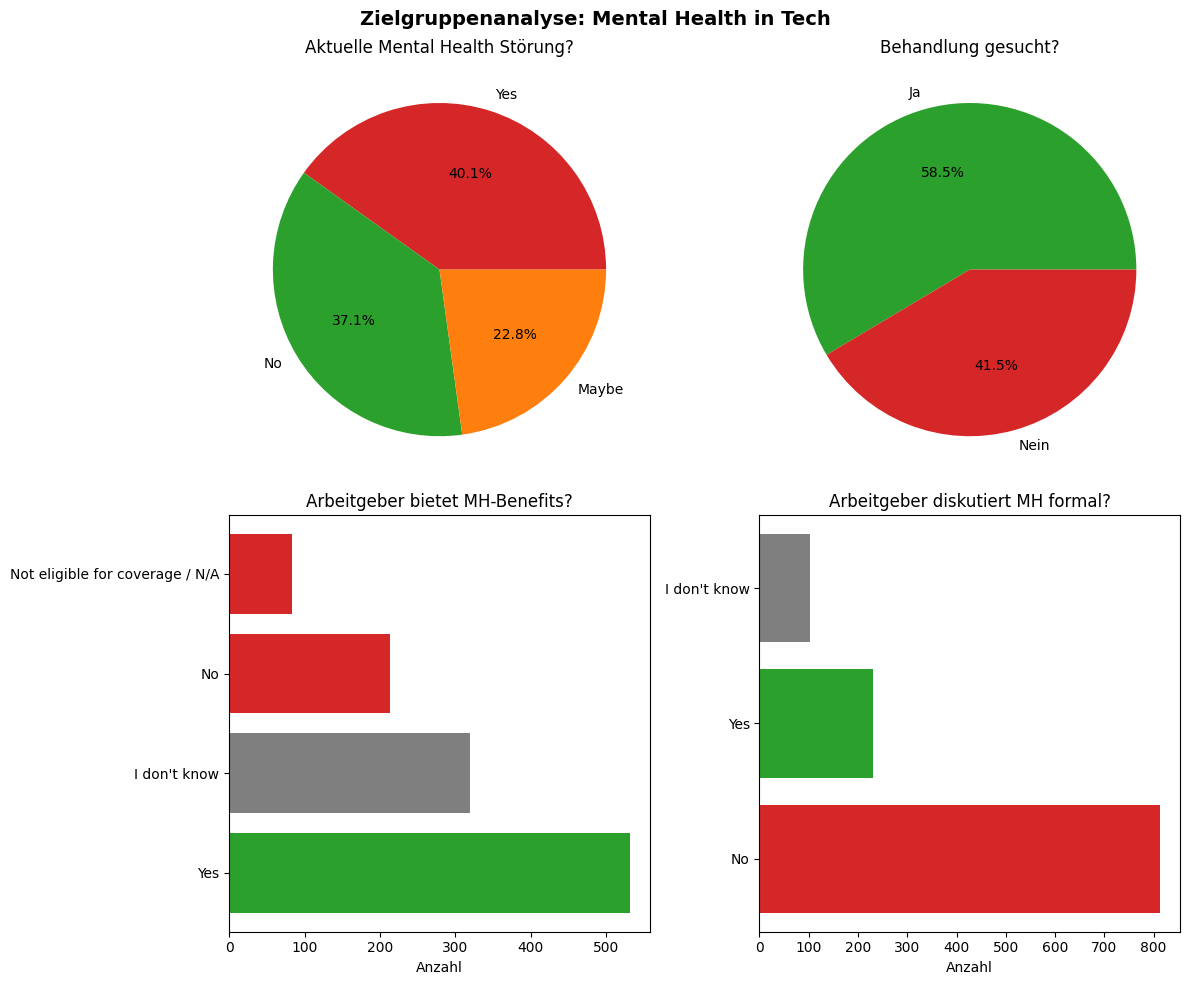

In [27]:
# =============================================================================
# ZIELGRUPPENANALYSE: Kernfragen (Diagramme)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Aktuelle MH-Störung (Pie)
ax1 = axes[0, 0]
current_mh = df[cols[47]].value_counts()
colors1 = ['#d62728', '#2ca02c', '#ff7f0e']
ax1.pie(current_mh.values, labels=current_mh.index, autopct='%1.1f%%', colors=colors1)
ax1.set_title('Aktuelle Mental Health Störung?')

# 2. Behandlung gesucht (Pie)
ax2 = axes[0, 1]
treatment = df[cols[52]].value_counts()
colors2 = ['#2ca02c', '#d62728']
ax2.pie(treatment.values, labels=['Ja', 'Nein'], autopct='%1.1f%%', colors=colors2)
ax2.set_title('Behandlung gesucht?')

# 3. MH-Benefits vom Arbeitgeber (Bar)
ax3 = axes[1, 0]
benefits = df[cols[4]].value_counts()
colors3 = ['#2ca02c' if 'Yes' in str(v) else '#d62728' if 'No' in str(v) else '#7f7f7f' for v in benefits.index]
ax3.barh(range(len(benefits)), benefits.values, color=colors3)
ax3.set_yticks(range(len(benefits)))
ax3.set_yticklabels(benefits.index)
ax3.set_xlabel('Anzahl')
ax3.set_title('Arbeitgeber bietet MH-Benefits?')

# 4. MH formal diskutiert (Bar)
ax4 = axes[1, 1]
discussed = df[cols[6]].value_counts()
colors4 = ['#2ca02c' if 'Yes' in str(v) else '#d62728' if 'No' in str(v) else '#7f7f7f' for v in discussed.index]
ax4.barh(range(len(discussed)), discussed.values, color=colors4)
ax4.set_yticks(range(len(discussed)))
ax4.set_yticklabels(discussed.index)
ax4.set_xlabel('Anzahl')
ax4.set_title('Arbeitgeber diskutiert MH formal?')

plt.suptitle('Zielgruppenanalyse: Mental Health in Tech', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/target_group_analysis.png', dpi=150, bbox_inches='tight')
plt.show()